In [2]:
import h5py
import numpy as  np
from pathlib import Path
import matplotlib.pyplot as plt
from source import helper
plt.rcParams["figure.figsize"] = (20,5)
plt.rcParams["image.interpolation"] = 'none'

In [2]:
BASE_DIR = Path("D:/Studia/sium/semestr3/radar-project/data")  # change to your project dir

loaded_file = h5py.File(BASE_DIR/'dataset.h5','r')
frames = loaded_file['8']['dataset_8']
frames = frames[:,0,0,:]

In [ ]:
# dostępne
# 'wiatrak_4m'
# 'wiatrak_2m'
# 'wiatrak_3m'
# 'wiatrak_1m'
# 'randomowe_chodzonko_1os_bartek'
# 'odleglosc_4m_bartek_bokiem'
# 'odleglosc_4m_bartek_przodem'
# 'odleglosc_3m_bartek_bokiem'
# 'odleglosc_3m_bartek_przodem'
# 'odleglosc_2m_bartek_bokiem'
# 'odleglosc_2m_bartek_przodem'
# 'odleglosc_1m_bartek_bokiem'
# 'odleglosc_1m_bartek_przodem'
# 'chodzonko_1os_4-1-8m_bartek'
# 'biegunko_1os_2m_rafal'
# 'chodzonko_1os_2m_bartek'

In [186]:
BASE_DIR = Path("D:/Studia/sium/semestr3/radar-project")  # change to your project dir
RADAR_DIR = BASE_DIR / "data/2023_03_21/chodzonko"  # day dir
GROUP_NAME = '2023_03_21' # nazwa grupy (np. dzień pomiaru), de facto to tylko kolejny wymiar
H5_FILENAME = 'alive_or_dead'

loaded_file = h5py.File('../data/'+ H5_FILENAME + '.h5','r')
frames = loaded_file[GROUP_NAME]['chodzonko_1os_2m_bartek']
frames = frames[:,0,0,:]

In [187]:
def gen_n_diff_spect(frames: np.array = None, distances: list=[0, 1, 10], use_db: bool = True) -> (list, np.ndarray):
    if frames is None:
        raise AttributeError("no frames specified")

    to_return = []
    for d in distances:
        if d == 0:
            spect,y = helper.gen_spectogram(frames)
            if use_db:
                spect = helper.to_dB(spect)
        else:
            spect = helper.diff_frames(frames,  d)
            spect,y =  helper.gen_spectogram(spect)
            if use_db:
                spect  = helper.to_dB(spect)

        to_return.append(spect[:,max(distances)-d:])
    return to_return,y

In [188]:
spects,y = gen_n_diff_spect(frames, distances=[0,1,5,10,20,50])

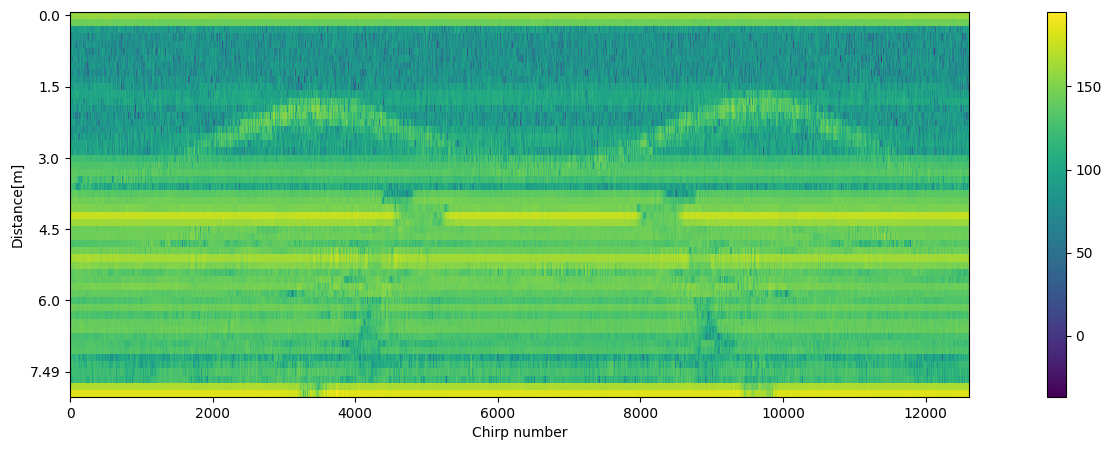

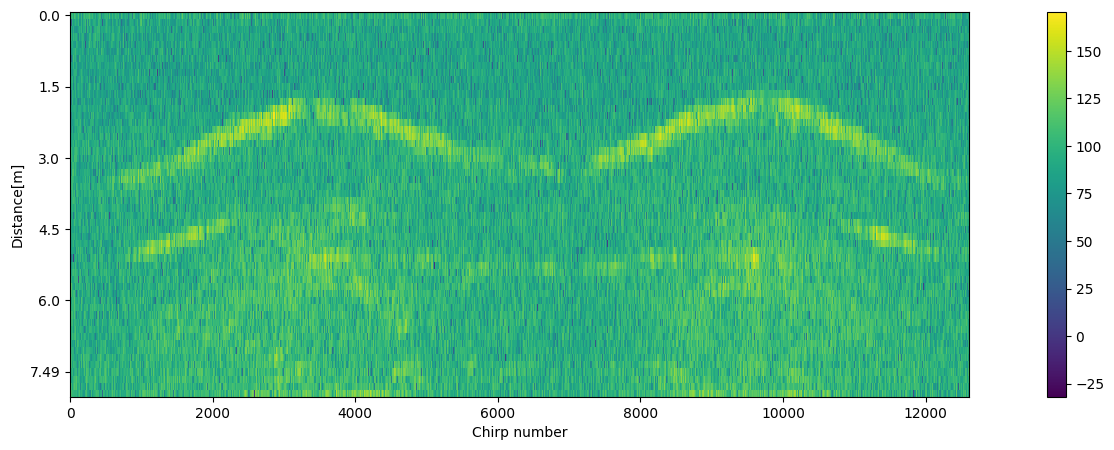

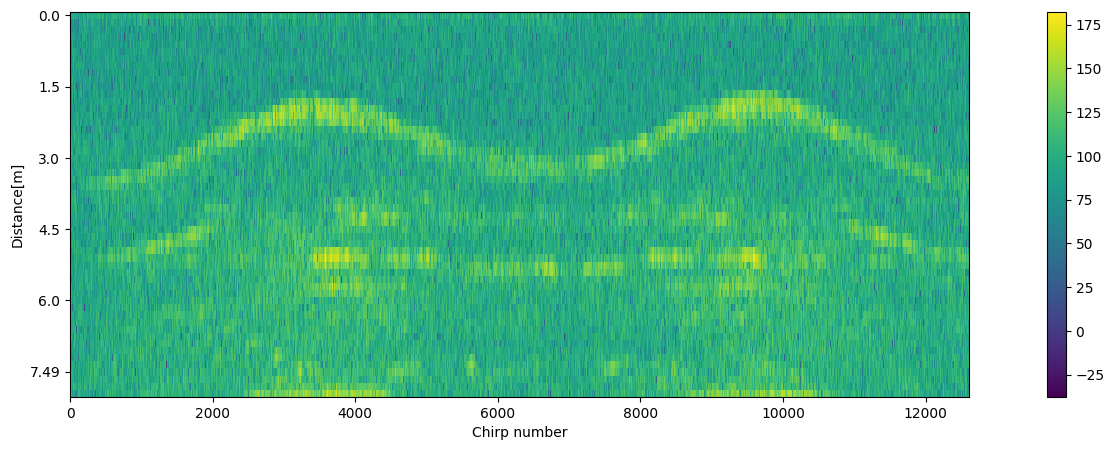

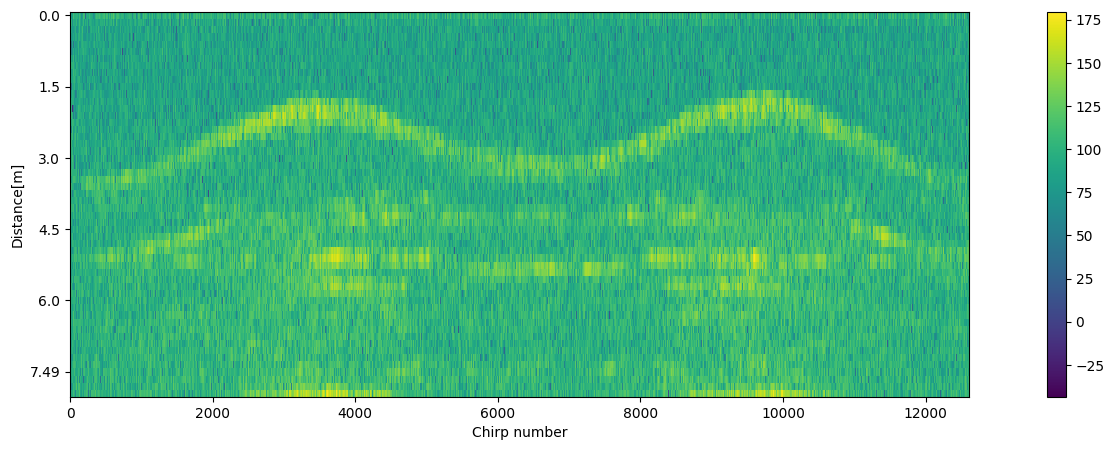

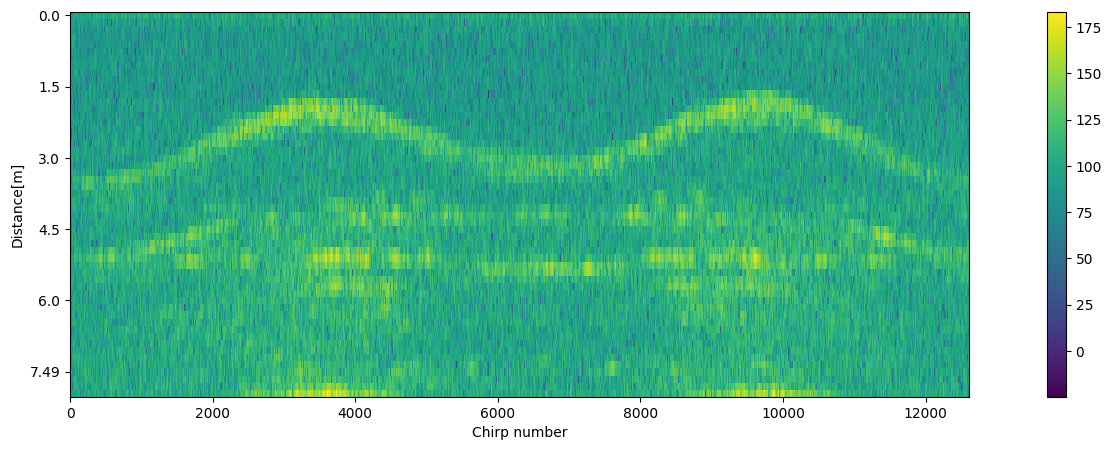

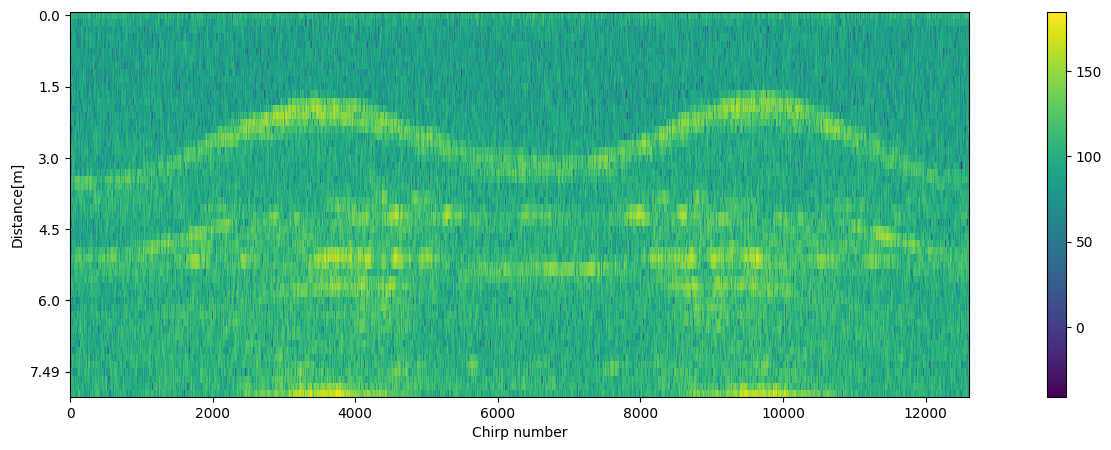

In [189]:
for s in spects:
    helper.print_spectogram(s,y,depth_limit=8, step=10, aspect=100)

In [190]:
def reduce_spectograms(spects: list, th: int=81) -> list:
    res = []
    for s in spects:
        res.append(s[:th,:])
    return res

In [191]:
max_i=50
reduced_spects = reduce_spectograms(spects,th=max_i)
reduced_y = y[:max_i]

In [192]:
normalized_spects = []
for s in reduced_spects:
    s[s==np.NINF] = 0
    normalized_spects.append(helper.normalize(s))

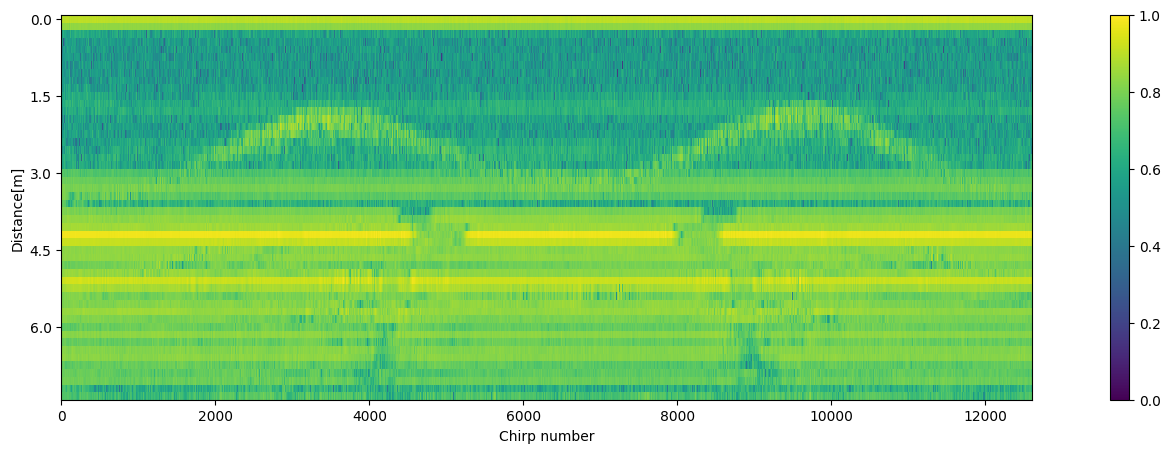

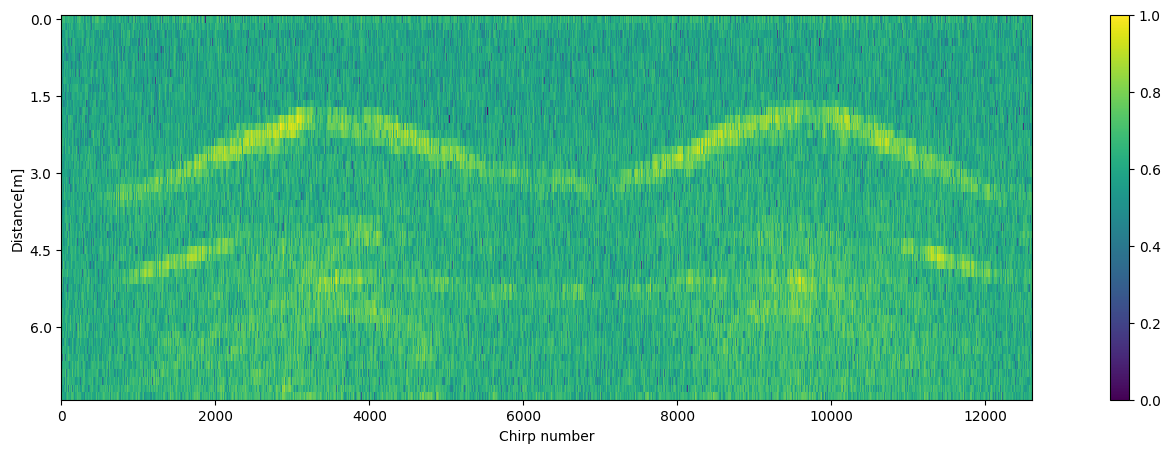

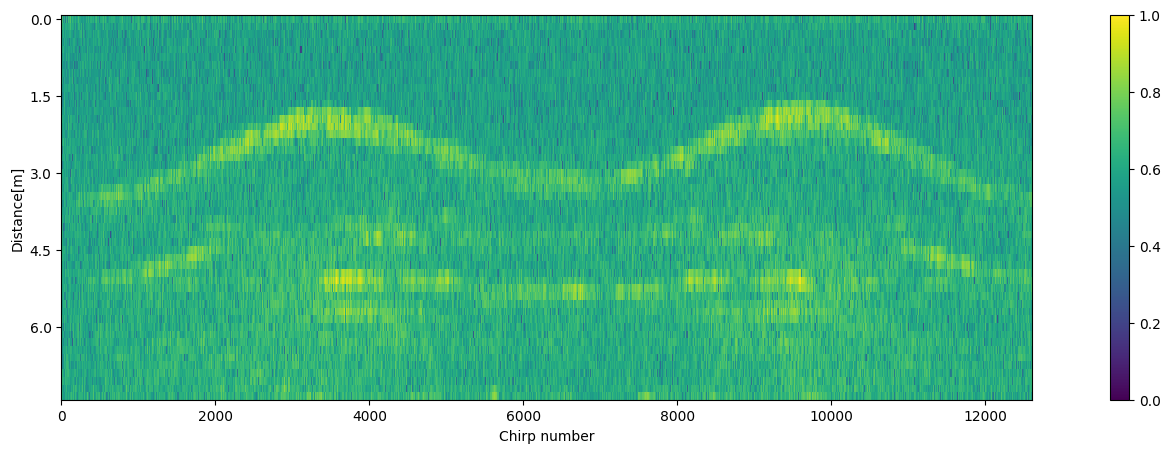

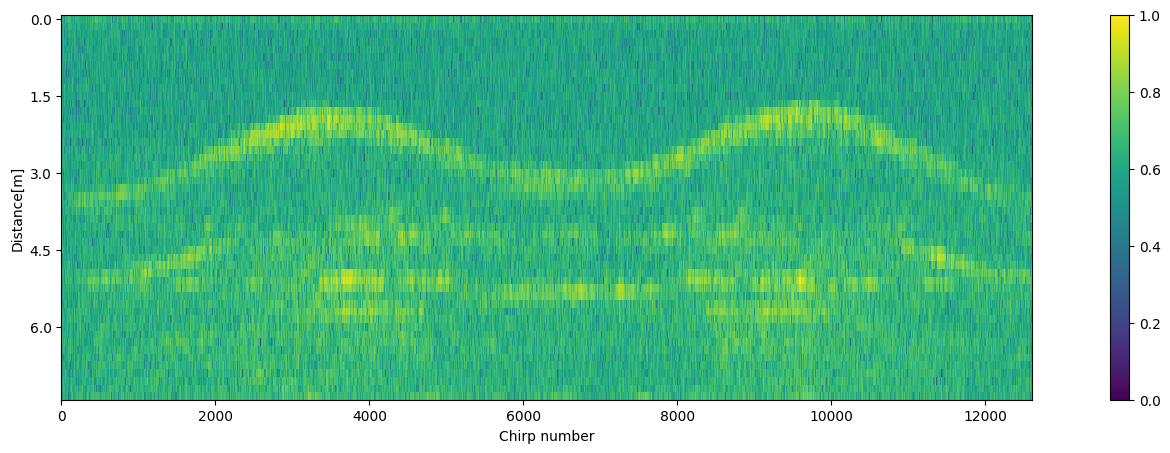

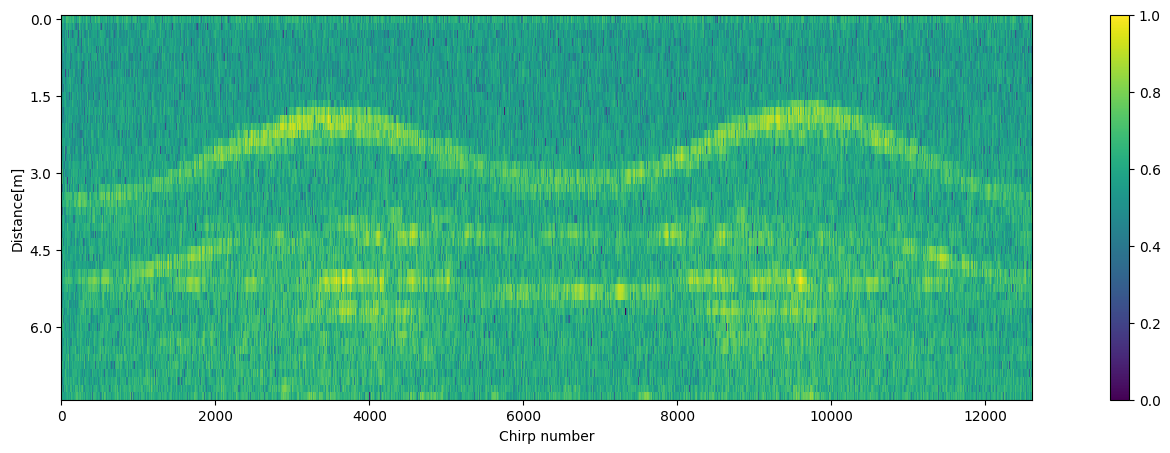

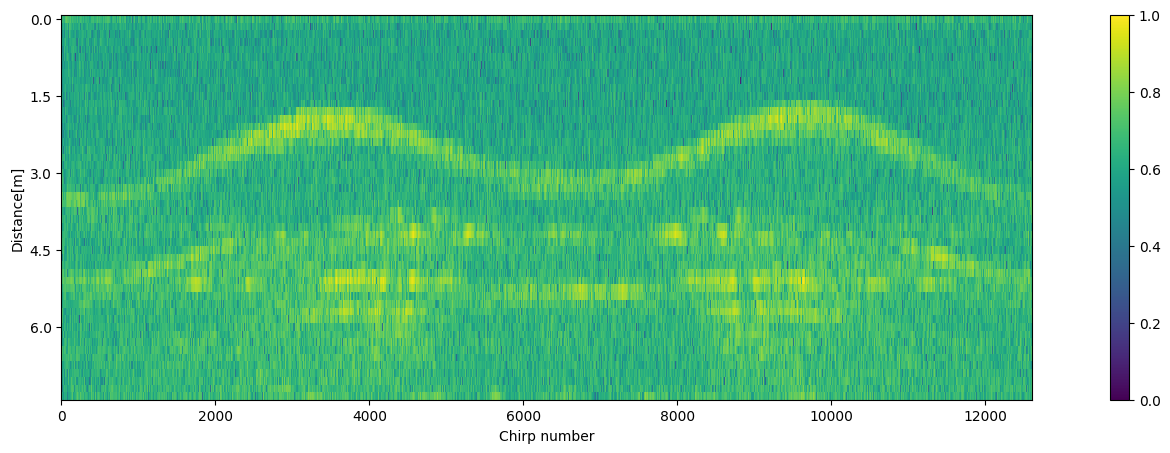

In [193]:
for s in normalized_spects:
    helper.print_spectogram(s,reduced_y,step=10, aspect=100)

In [194]:
from scipy.signal import find_peaks,peak_prominences, find_peaks_cwt

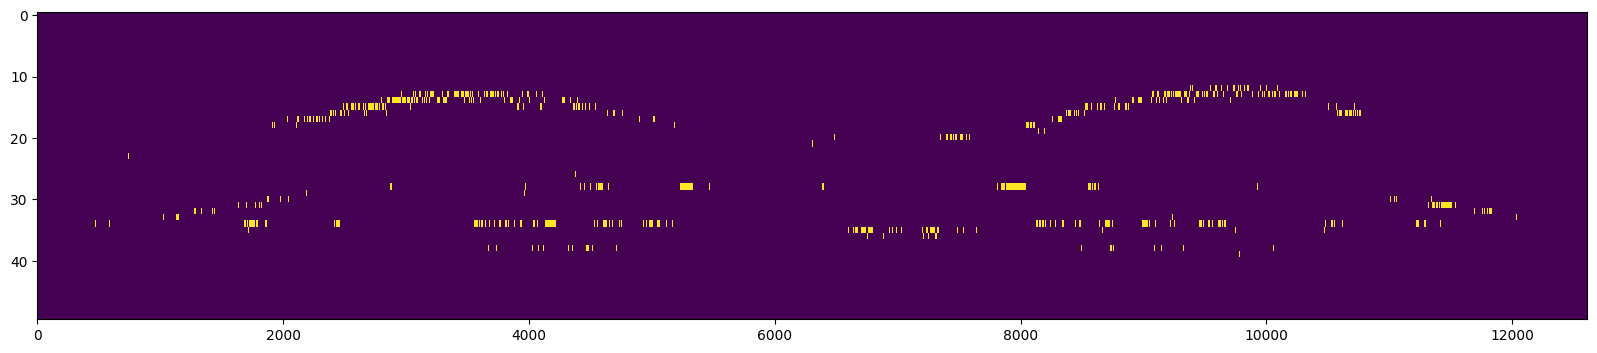

In [195]:
trajectory_base =  normalized_spects[5]
trajectory =np.zeros_like(trajectory_base)
th = np.percentile(trajectory_base, 98)
for i, v in enumerate(trajectory_base.T):
    peaks, _ = find_peaks(v)
    if len(peaks)==0:
        continue
    prominences = peak_prominences(v, peaks)

    peaks, _ = find_peaks(v, prominence=[np.percentile(prominences[0], 98),None], height=th, width=1)
    trajectory[peaks, i] = 1
plt.imshow(trajectory, aspect=50, interpolation='none')

In [196]:
def remove_singles(trajektory: np.ndarray, n: int=1):
    res = np.copy(trajektory)
    for i,v in enumerate(trajektory.T):
        possible = np.where(v ==1)
        for p in possible[0]:
            try:
                next = trajektory[p-n:p+n, i+1]
                if np.max(next) == 0:
                    res[p,i] = 0
            except:
                pass

    return res

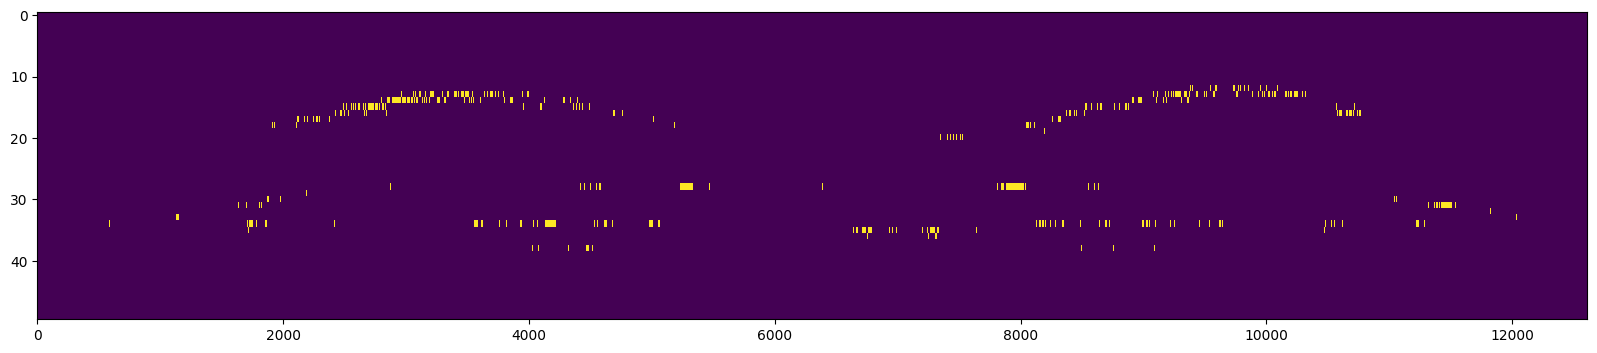

In [197]:
cleaned_trajectory = remove_singles(trajectory, n=2)
plt.imshow(cleaned_trajectory, aspect=50, interpolation='none')

In [198]:
(cleaned_trajectory == trajectory).all()

False

Trajektorja nałożona na spektogramy, widać że jest sporo do poprawy, zwłaszcza przy nieruchomym człowieku

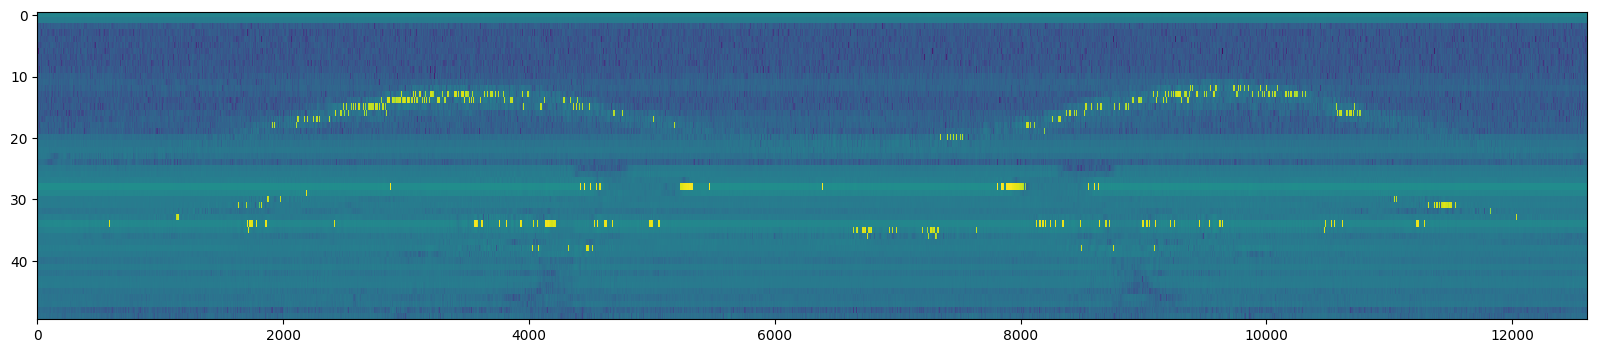

In [199]:
sumed = normalized_spects[0]+cleaned_trajectory
plt.imshow(sumed, aspect=50, interpolation='none')

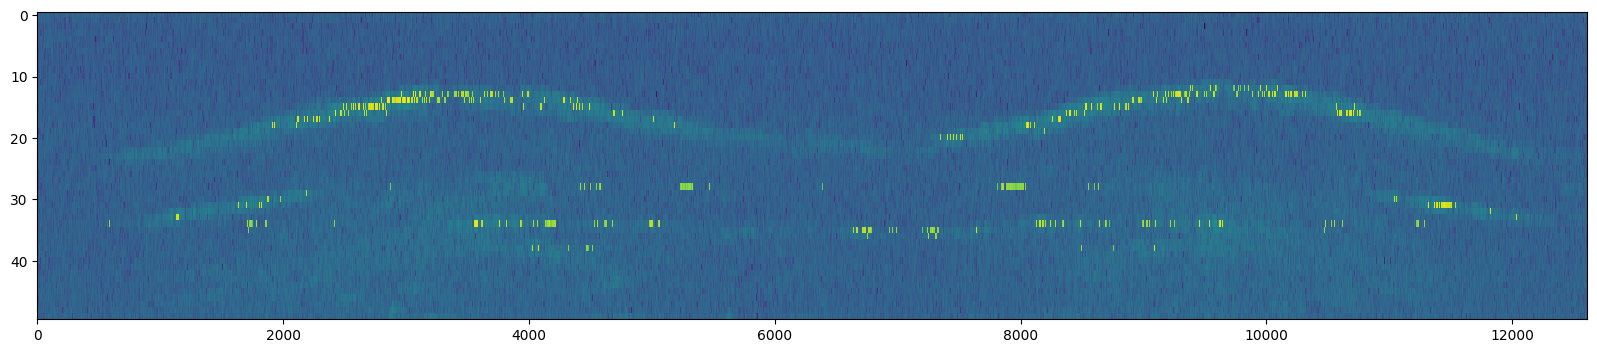

In [200]:
sumed = normalized_spects[1]+cleaned_trajectory
plt.imshow(sumed, aspect=50, interpolation='none')

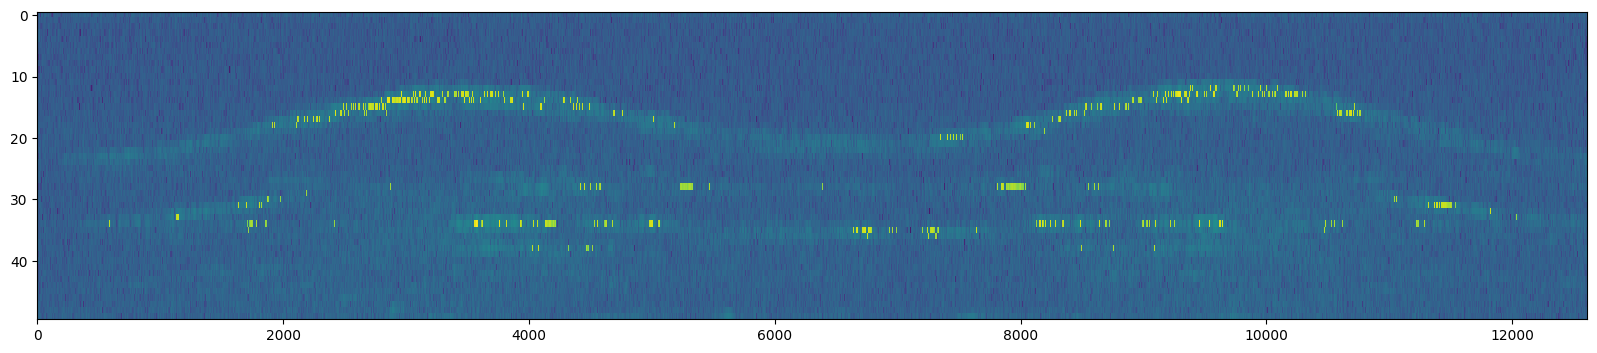

In [201]:
sumed = normalized_spects[2]+cleaned_trajectory
plt.imshow(sumed, aspect=50, interpolation='none')

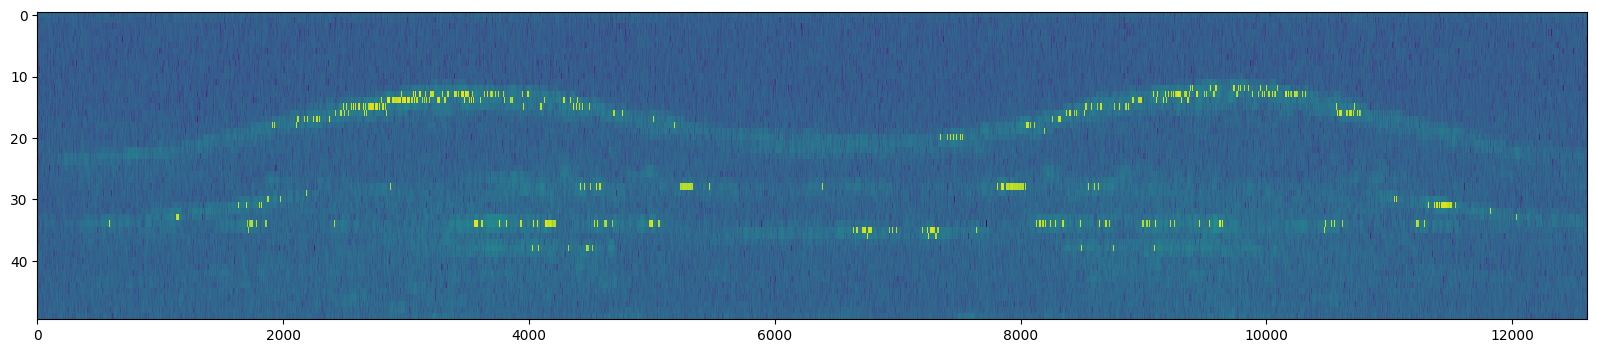

In [202]:
sumed = normalized_spects[3]+cleaned_trajectory
plt.imshow(sumed, aspect=50, interpolation='none')

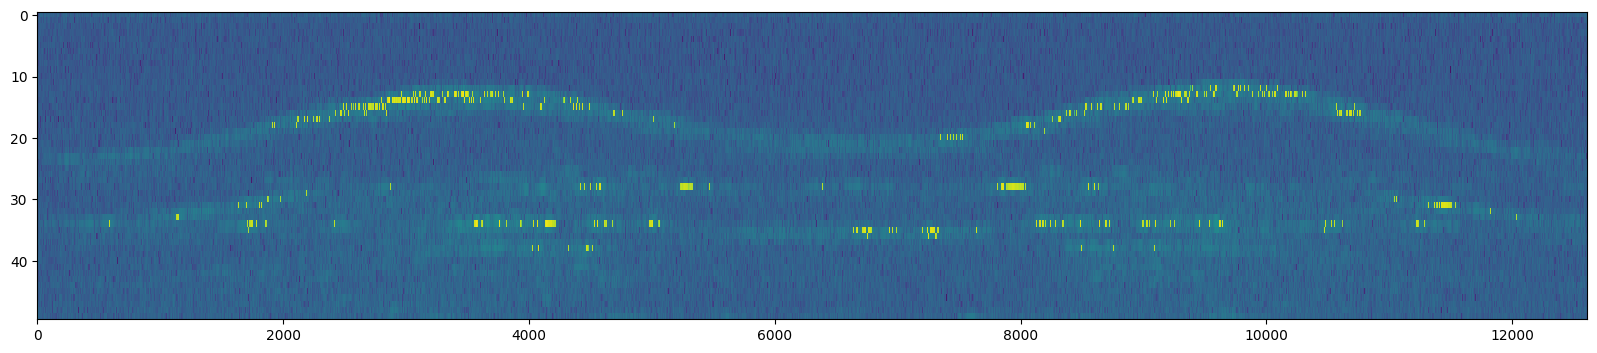

In [203]:
sumed = normalized_spects[4]+cleaned_trajectory
plt.imshow(sumed, aspect=50, interpolation='none')

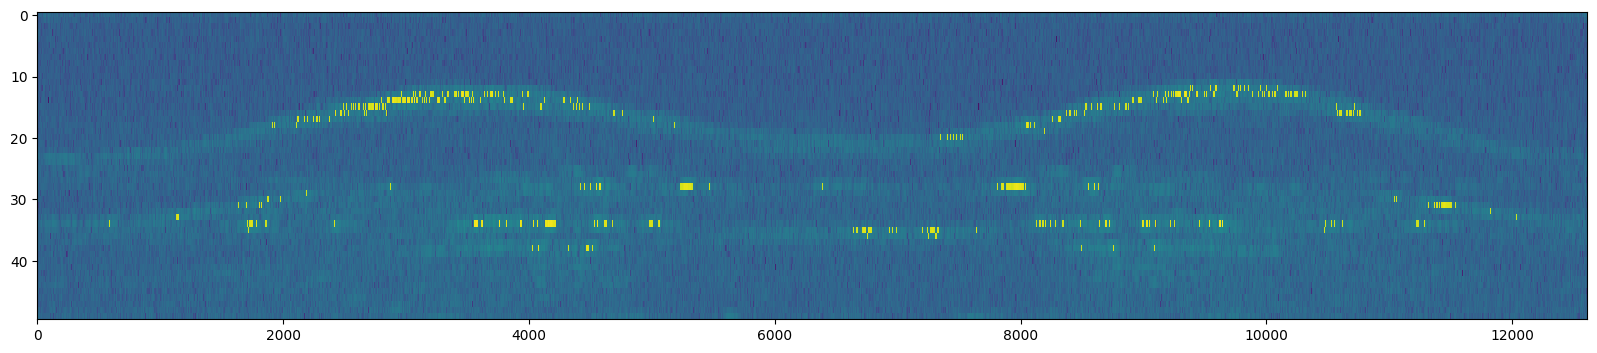

In [204]:
sumed = normalized_spects[5]+cleaned_trajectory
plt.imshow(sumed, aspect=50, interpolation='none')

In [205]:
loaded_file.close()